In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from phik import resources, report
from phik.report import plot_correlation_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import BaseEstimator, TransformerMixin
import joblib
import os

In [21]:
ruta_dataset = os.path.join("..", "data", "raw", "Telco_churn.csv")
df = pd.read_csv(ruta_dataset)

In [22]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [23]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [24]:


# 1. Separar X e y
X = df.drop(columns=['customerID', 'Churn'])
y = df['Churn'].map({'No': 0, 'Yes': 1})

# 2. Columnas categóricas (completas y correctas)
cat_features_names = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

# 3. Convertir columnas categóricas a string
for col in cat_features_names:
    X[col] = X[col].astype(str)

# 4. Asegurar que numéricas estén bien y sin NaNs
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in num_cols:
    X[col] = pd.to_numeric(X[col], errors='coerce')
    X[col] = X[col].fillna(X[col].median())

# 5. Obtener índices de columnas categóricas
cat_features = [X.columns.get_loc(col) for col in cat_features_names]

# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)

# 7. Pesos de clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# 8. Modelo base
model = CatBoostClassifier(
    random_seed=82,
    verbose=0,
    class_weights=class_weights
)

# 9. Grid de hiperparámetros
param_grid = {
    'iterations': [100, 200],
    'depth': [4, 6, 8],
    'learning_rate': [0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

# 10. GridSearch
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    error_score='raise'
)

# 11. Entrenar el modelo
grid_search.fit(X_train, y_train, cat_features=cat_features)

# 12. Resultados
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor Recall:", grid_search.best_score_)

# 13. Evaluación
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)

print(classification_report(y_test, y_pred))
print("AUC-ROC:", round(auc_score, 3))


Mejores parámetros: {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
Mejor Recall: 0.8175720992622401
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1031
           1       0.52      0.80      0.63       378

    accuracy                           0.75      1409
   macro avg       0.71      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409

AUC-ROC: 0.843


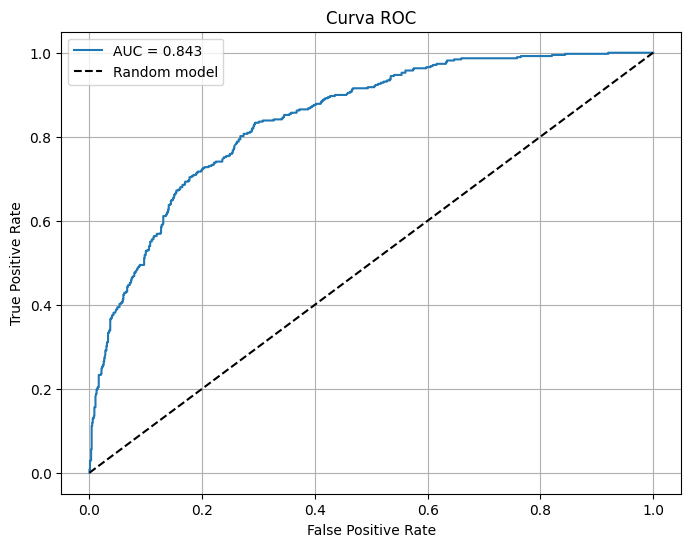

In [27]:

# Graficar la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
from catboost import Pool

# Obtener importancias
feature_importances = best_model.get_feature_importance(Pool(X_test, label=y_test, cat_features=cat_features))

# Combinar nombres e importancias y ordenar de mayor a menor
sorted_importances = sorted(zip(X_test.columns, feature_importances), key=lambda x: x[1], reverse=True)

# Imprimir
for name, importance in sorted_importances:
    print(f"{name}: {importance:.2f}")


Contract: 33.39
MonthlyCharges: 17.40
tenure: 13.76
TotalCharges: 9.52
OnlineSecurity: 6.63
TechSupport: 4.24
PaymentMethod: 3.85
PaperlessBilling: 2.82
InternetService: 2.28
OnlineBackup: 1.57
MultipleLines: 1.44
PhoneService: 0.81
StreamingTV: 0.73
SeniorCitizen: 0.71
gender: 0.34
Dependents: 0.29
Partner: 0.22
DeviceProtection: 0.00
StreamingMovies: 0.00


Voy a intentar ajustar mas el modelo, veo que estas variables son menos importantes. Las elimino para ver si el recall mejora

DeviceProtection: 0.69

StreamingTV: 0.61

gender: 0.33

PhoneService: 0.03

Dependents: 0.00

TechSupport: 0.00

StreamingMovies: 0.00

In [32]:
df = pd.read_csv(ruta_dataset)

# 1. Separar X e y
X = df.drop(columns=['customerID', 'Churn','customerID', 'DeviceProtection', 'StreamingTV', 'gender',
        'PhoneService', 'Dependents', 'TechSupport', 'StreamingMovies'])
y = df['Churn'].map({'No': 0, 'Yes': 1})

# 2. Columnas categóricas (completas y correctas)
cat_features_names = [
    'SeniorCitizen', 'Partner', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

# 3. Convertir columnas categóricas a string
for col in cat_features_names:
    X[col] = X[col].astype(str)

# 4. Asegurar que numéricas estén bien y sin NaNs
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in num_cols:
    X[col] = pd.to_numeric(X[col], errors='coerce')
    X[col] = X[col].fillna(X[col].median())

# 5. Obtener índices de columnas categóricas
cat_features = [X.columns.get_loc(col) for col in cat_features_names]

# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)

# 7. Pesos de clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# 8. Modelo base
model = CatBoostClassifier(
    random_seed=82,
    verbose=0,
    class_weights=class_weights
)

# 9. Grid de hiperparámetros
param_grid = {
    'iterations': [100, 200],
    'depth': [4, 6, 8],
    'learning_rate': [0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

# 10. GridSearch
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    error_score='raise'
)

# 11. Entrenar el modelo
grid_search.fit(X_train, y_train, cat_features=cat_features)

# 12. Resultados
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor Recall:", grid_search.best_score_)

# 13. Evaluación
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Mejores parámetros: {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Mejor Recall: 0.8148893360160966
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1031
           1       0.51      0.79      0.62       378

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



In [31]:


df = pd.read_csv(ruta_dataset)


y = df["Churn"].map({"Yes": 1, "No": 0})

# Eliminar columnas irrelevantes
cols_drop = [
    'customerID', 'DeviceProtection', 'StreamingTV', 'gender',
    'PhoneService', 'Dependents', 'TechSupport', 'StreamingMovies'
]
df = df.drop(columns=cols_drop)

X = df.drop(columns=["Churn"])

# Columnas categóricas y numéricas
cat_cols = [
    'SeniorCitizen', 'Partner', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'Contract', 'PaperlessBilling', 'PaymentMethod'
]
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=82, stratify=y
)


# Limpiar: reemplazar strings vacíos o inválidos
for col in num_cols:
    X_train[col] = pd.to_numeric(X_train[col].replace(" ", np.nan), errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col].replace(" ", np.nan), errors='coerce')

# Imputar con mediana
imputer = SimpleImputer(strategy="median")
X_train[num_cols] = imputer.fit_transform(X_train[num_cols])
X_test[num_cols] = imputer.transform(X_test[num_cols])

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

X_train_cat = encoder.fit_transform(X_train[cat_cols])
X_test_cat = encoder.transform(X_test[cat_cols])

# Obtener los nombres de las columnas generadas
encoded_cat_cols = encoder.get_feature_names_out(cat_cols)

# Convertir a DataFrame para unir
X_train_cat_df = pd.DataFrame(X_train_cat, columns=encoded_cat_cols, index=X_train.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=encoded_cat_cols, index=X_test.index)

# Quitar columnas categóricas originales
X_train = X_train.drop(columns=cat_cols)
X_test = X_test.drop(columns=cat_cols)

# Unir numéricas y categóricas transformadas
X_train_final = pd.concat([X_train, X_train_cat_df], axis=1)
X_test_final = pd.concat([X_test, X_test_cat_df], axis=1)


class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights_array[0], 1: class_weights_array[1]}

# Entrenar modelo
model = CatBoostClassifier(
    iterations=100,
    depth=4,
    learning_rate=0.1,
    l2_leaf_reg=1,
    random_seed=82,
    verbose=0,
    class_weights=class_weights
)

model.fit(X_train_final, y_train)

# Evaluacion
y_pred = model.predict(X_test_final)
y_proba = model.predict_proba(X_test_final)[:, 1]

print("Modelo entrenado correctamente.")
print("\n Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.3f}")


Modelo entrenado correctamente.

 Matriz de Confusión:
[[763 272]
 [ 75 299]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.74      0.81      1035
           1       0.52      0.80      0.63       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.77      1409

AUC-ROC: 0.852


Modelo mejora, es mejor que los demas me quedo con este. 

Lo encapsulo en un pipeline para que me funcione con Streamlit.

In [ ]:
ruta_modelo = r"C:\Users\Merche\REPOSITORIO_MI_PORTFOLIO\Predictor de Churn\ML\models\modelo_catboost.joblib"
joblib.dump(model, ruta_modelo)

Guardo el train y el test para el proyecto

In [33]:

ruta_train = r'C:\Users\Merche\REPOSITORIO_MI_PORTFOLIO\Predictor de Churn\ML\data\train'
ruta_test = r'C:\Users\Merche\REPOSITORIO_MI_PORTFOLIO\Predictor de Churn\ML\data\test'

# Guardar archivos de entrenamiento
X_train.to_csv(os.path.join(ruta_train, 'X_train.csv'), index=False)
y_train.to_csv(os.path.join(ruta_train, 'y_train.csv'), index=False)

# Guardar archivos de test
X_test.to_csv(os.path.join(ruta_test, 'X_test.csv'), index=False)
y_test.to_csv(os.path.join(ruta_test, 'y_test.csv'), index=False)